# NB08: Conserved Gene Neighborhoods, Cofit-Validated Operons & Improved Prioritization

## Problem
NB07's gene neighborhood analysis uses a minimal positional heuristic (5-gene window, same-strand + 300bp gap, keyword grep).
This is far below industry standard (DOOR, STRING, EFI-GNT) which use **cross-species synteny** and **co-expression validation**.

## Strategy
1. **Conserved gene neighborhoods**: For each dark gene + operon partner, check if orthologs of both are also neighbors in other FB organisms (STRING "neighborhood" signal)
2. **Cofit-validated operons**: Check whether dark gene and operon partner are each other's cofit partners
3. **Improved prioritization**: Re-score candidates with new synteny + cofit evidence
4. **Experimental roadmap**: Rank organism × condition experiments with evidence-weighted scoring

## Inputs
- `dark_genes_integrated.tsv` — 228,709 genes (all 48 organisms)
- `gene_neighbor_context.tsv` — 57,011 dark genes with neighbor analysis
- `prioritized_candidates.tsv` — top 100 fitness-active candidates
- `essential_prioritized_candidates.tsv` — top 50 essential candidates
- `all_ortholog_groups.csv` — 179,237 ortholog group assignments
- `all_predictions_summary.csv` — 6,691 module-based function predictions
- `essential_predictions.tsv` — 1,381 essential gene predictions
- FB `gene` table (Spark) — gene positions for all 48 organisms
- FB `cofit` table (Spark) — co-fitness correlations (13.6M rows)

## Outputs
- `conserved_neighborhoods.tsv` — per-pair synteny scores
- `cofit_validated_operons.tsv` — per-pair cofit validation
- `improved_candidates.tsv` — re-scored candidates with new evidence
- `experimental_roadmap.tsv` — ranked organism × condition recommendations
- Figures 22–24

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Spark session (injected by BERDL JupyterHub kernel)
spark = get_spark_session()

# Project paths
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Upstream project paths
_d = PROJECT_DIR
REPO_ROOT = PROJECT_DIR
while _d != '/':
    if os.path.exists(os.path.join(_d, 'PROJECT.md')):
        REPO_ROOT = _d
        break
    _d = os.path.dirname(_d)

EG_DATA = os.path.join(REPO_ROOT, 'projects', 'essential_genome', 'data')
FM_PRED = os.path.join(REPO_ROOT, 'projects', 'fitness_modules', 'data', 'predictions')

print(f'PROJECT_DIR: {PROJECT_DIR}')
print(f'EG_DATA: {EG_DATA}')
print(f'FM_PRED: {FM_PRED}')

PROJECT_DIR: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter
EG_DATA: /home/aparkin/BERIL-research-observatory/projects/essential_genome/data
FM_PRED: /home/aparkin/BERIL-research-observatory/projects/fitness_modules/data/predictions


In [2]:
# Load all input files
dark_genes = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t')
neighbors = pd.read_csv(os.path.join(DATA_DIR, 'gene_neighbor_context.tsv'), sep='\t')
top100 = pd.read_csv(os.path.join(DATA_DIR, 'prioritized_candidates.tsv'), sep='\t')
ess_top50 = pd.read_csv(os.path.join(DATA_DIR, 'essential_prioritized_candidates.tsv'), sep='\t')
og_df = pd.read_csv(os.path.join(EG_DATA, 'all_ortholog_groups.csv'))
predictions = pd.read_csv(os.path.join(FM_PRED, 'all_predictions_summary.csv'))
ess_preds = pd.read_csv(os.path.join(EG_DATA, 'essential_predictions.tsv'), sep='\t')

# Also load scoring files for re-scoring
scoring_active = pd.read_csv(os.path.join(DATA_DIR, 'scoring_all_dark.tsv'), sep='\t')
scoring_essential = pd.read_csv(os.path.join(DATA_DIR, 'essential_dark_scored.tsv'), sep='\t')

print(f'dark_genes: {dark_genes.shape}')
print(f'neighbors (dark only): {neighbors.shape}')
print(f'top100 candidates: {top100.shape}')
print(f'ess_top50 candidates: {ess_top50.shape}')
print(f'ortholog groups: {og_df.shape}')
print(f'module predictions: {predictions.shape}')
print(f'essential predictions: {ess_preds.shape}')
print(f'scoring_active: {scoring_active.shape}')
print(f'scoring_essential: {scoring_essential.shape}')

/tmp/ipykernel_42531/2179489601.py:2: DtypeWarning: Columns (0: gene, 1: module, 2: familyId, 3: module_prediction, 4: prediction_source, 5: top_cofit_partners) have mixed types. Specify dtype option on import or set low_memory=False.
  dark_genes = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_integrated.tsv'), sep='\t')


dark_genes: (228709, 43)
neighbors (dark only): (57011, 17)
top100 candidates: (100, 33)
ess_top50 candidates: (50, 26)
ortholog groups: (179237, 3)
module predictions: (6691, 14)
essential predictions: (1382, 14)
scoring_active: (17344, 30)
scoring_essential: (9557, 23)


---
## Section 1: Conserved Gene Neighborhoods

**Strategy**: For each dark gene + operon partner pair identified in NB07, check if orthologs of both genes
are also neighbors in other FB organisms. This is the STRING "neighborhood" signal — if two genes are
consistently adjacent across multiple genomes, they likely function together.

**Steps**:
1. Load FB gene positions from Spark
2. Re-derive operon partner locusIds (NB07 only saved descriptions, not IDs)
3. Build ortholog group lookup tables
4. Check synteny conservation across organisms

In [3]:
# Load FB gene positions from Spark
fb_genes_sdf = spark.sql("""
    SELECT orgId, locusId, sysName, gene, `desc`,
           scaffoldId, CAST(`begin` AS INT) AS begin_pos,
           CAST(`end` AS INT) AS end_pos, strand
    FROM kescience_fitnessbrowser.gene
""")
fb_genes = fb_genes_sdf.toPandas()
print(f'FB genes loaded: {fb_genes.shape[0]:,} rows, {fb_genes["orgId"].nunique()} organisms')

# Classify annotation status (same logic as NB07)
def classify_desc(desc):
    if pd.isna(desc) or desc.strip() == '':
        return 'no_annotation'
    desc_lower = desc.lower()
    if 'hypothetical' in desc_lower:
        return 'hypothetical'
    if 'duf' in desc_lower:
        return 'DUF'
    if 'uncharacterized' in desc_lower or 'unknown' in desc_lower:
        return 'uncharacterized'
    return 'annotated'

fb_genes['annot_class'] = fb_genes['desc'].apply(classify_desc)
fb_genes['is_dark'] = fb_genes['annot_class'] != 'annotated'

print(f'\nAnnotation breakdown:')
print(fb_genes['annot_class'].value_counts())

FB genes loaded: 228,709 rows, 48 organisms

Annotation breakdown:
annot_class
annotated          171354
hypothetical        48710
DUF                  3675
uncharacterized      3594
no_annotation        1376
Name: count, dtype: int64


In [4]:
# Re-derive operon partner locusIds by replaying NB07 heuristic
# NB07 used: same-strand, gap <= 300bp, 5-gene window
# But only saved descriptions, not partner locusIds

NEIGHBOR_WINDOW = 5
OPERON_MAX_GAP = 300

# Filter to dark genes that have annotated operon partners
dark_with_operon = neighbors[neighbors['n_operon_annotated'] > 0].copy()
print(f'Dark genes with annotated operon partners: {len(dark_with_operon):,}')

# Build gene position index: sort genes per organism per scaffold
fb_genes_sorted = fb_genes.sort_values(['orgId', 'scaffoldId', 'begin_pos']).reset_index(drop=True)
fb_genes_sorted['ordinal'] = fb_genes_sorted.groupby(['orgId', 'scaffoldId']).cumcount()

# Build lookup: (orgId, locusId) -> row
gene_lookup = {}
for _, row in fb_genes_sorted.iterrows():
    gene_lookup[(row['orgId'], row['locusId'])] = row

# Build scaffold gene lists: (orgId, scaffoldId) -> sorted list of (ordinal, locusId, begin_pos, end_pos, strand, is_dark, annot_class, desc)
scaffold_genes = defaultdict(list)
for _, row in fb_genes_sorted.iterrows():
    scaffold_genes[(row['orgId'], row['scaffoldId'])].append((
        row['ordinal'], row['locusId'], row['begin_pos'], row['end_pos'],
        row['strand'], row['is_dark'], row['annot_class'], row['desc']
    ))

print(f'Gene lookup: {len(gene_lookup):,} entries')
print(f'Scaffold groups: {len(scaffold_genes):,}')

# Re-derive operon pairs
operon_pairs = []
missing_genes = 0

for _, drow in dark_with_operon.iterrows():
    org = drow['orgId']
    loc = drow['locusId']
    scaf = drow['scaffoldId']
    
    key = (org, loc)
    if key not in gene_lookup:
        missing_genes += 1
        continue
    
    target = gene_lookup[key]
    target_strand = target['strand']
    target_begin = target['begin_pos']
    target_end = target['end_pos']
    target_ord = target['ordinal']
    
    genes_on_scaffold = scaffold_genes.get((org, scaf), [])
    if not genes_on_scaffold:
        continue
    
    for g_ord, g_loc, g_begin, g_end, g_strand, g_is_dark, g_annot, g_desc in genes_on_scaffold:
        if g_loc == loc:
            continue
        # Within 5-gene window
        if abs(g_ord - target_ord) > NEIGHBOR_WINDOW:
            continue
        # Same strand
        if g_strand != target_strand:
            continue
        # Gap check
        if g_begin > target_end:
            gap = g_begin - target_end
        elif target_begin > g_end:
            gap = target_begin - g_end
        else:
            gap = 0  # overlapping
        if gap > OPERON_MAX_GAP:
            continue
        # Must be annotated partner
        if g_annot != 'annotated':
            continue
        
        operon_pairs.append({
            'orgId': org,
            'dark_locusId': loc,
            'partner_locusId': g_loc,
            'partner_desc': g_desc,
            'gap_bp': gap,
            'dark_strand': target_strand
        })

operon_pairs_df = pd.DataFrame(operon_pairs)
print(f'\nOperon pairs re-derived: {len(operon_pairs_df):,}')
print(f'Unique dark genes: {operon_pairs_df["dark_locusId"].nunique():,}')
print(f'Missing genes (not in FB): {missing_genes}')
print(f'\nPairs per dark gene:')
print(operon_pairs_df.groupby(['orgId', 'dark_locusId']).size().describe())

Dark genes with annotated operon partners: 30,190


Gene lookup: 228,709 entries
Scaffold groups: 174



Operon pairs re-derived: 38,264
Unique dark genes: 29,110
Missing genes (not in FB): 0

Pairs per dark gene:
count    30190.000000
mean         1.267440
std          0.452694
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
dtype: float64


In [5]:
# Build OG lookup tables from all_ortholog_groups.csv
# Columns: OG_id, orgId, locusId

locus_to_og = {}  # (orgId, locusId) -> OG_id
og_to_members = defaultdict(list)  # OG_id -> [(orgId, locusId), ...]
og_org_loci = defaultdict(list)  # (OG_id, orgId) -> [locusId, ...]

for _, row in og_df.iterrows():
    og = row['OG_id']
    org = row['orgId']
    loc = row['locusId']
    locus_to_og[(org, loc)] = og
    og_to_members[og].append((org, loc))
    og_org_loci[(og, org)].append(loc)

# Coverage stats
n_dark_with_og = sum(1 for _, r in operon_pairs_df.iterrows()
                     if (r['orgId'], r['dark_locusId']) in locus_to_og)
n_partner_with_og = sum(1 for _, r in operon_pairs_df.iterrows()
                        if (r['orgId'], r['partner_locusId']) in locus_to_og)

# Unique dark genes and partners with OG
unique_dark = operon_pairs_df[['orgId', 'dark_locusId']].drop_duplicates()
unique_dark_with_og = sum(1 for _, r in unique_dark.iterrows()
                          if (r['orgId'], r['dark_locusId']) in locus_to_og)

print(f'OG lookup: {len(locus_to_og):,} gene -> OG mappings')
print(f'Unique OGs: {len(og_to_members):,}')
print(f'\nOG coverage for operon pairs:')
print(f'  Dark genes with OG: {n_dark_with_og:,} / {len(operon_pairs_df):,} pairs ({n_dark_with_og/len(operon_pairs_df)*100:.1f}%)')
print(f'  Partners with OG: {n_partner_with_og:,} / {len(operon_pairs_df):,} pairs ({n_partner_with_og/len(operon_pairs_df)*100:.1f}%)')
print(f'  Unique dark genes with OG: {unique_dark_with_og:,} / {len(unique_dark):,} ({unique_dark_with_og/len(unique_dark)*100:.1f}%)')

OG lookup: 179,237 gene -> OG mappings
Unique OGs: 17,222

OG coverage for operon pairs:
  Dark genes with OG: 22,952 / 38,264 pairs (60.0%)
  Partners with OG: 31,863 / 38,264 pairs (83.3%)
  Unique dark genes with OG: 17,774 / 30,190 (58.9%)


In [6]:
# Build per-organism gene position index
# gene_position: (orgId, locusId) -> (scaffoldId, ordinal)

gene_position = {}
for _, row in fb_genes_sorted.iterrows():
    gene_position[(row['orgId'], row['locusId'])] = (row['scaffoldId'], row['ordinal'])

print(f'Gene position index: {len(gene_position):,} entries')
print(f'Organisms: {fb_genes_sorted["orgId"].nunique()}')

Gene position index: 228,709 entries
Organisms: 48


In [7]:
# Core synteny algorithm
# For each operon pair (dark gene D, partner P):
#   1. Look up D's OG and P's OG
#   2. Find other organisms that have both OGs
#   3. Check if members of both OGs are within 5 gene positions on same scaffold
#   4. Score = n_conserved / n_tested

SYNTENY_WINDOW = 5  # max gene positions apart to count as neighbors

synteny_results = []
n_both_og = 0
n_no_og = 0

for _, pair in operon_pairs_df.iterrows():
    org = pair['orgId']
    dark_loc = pair['dark_locusId']
    partner_loc = pair['partner_locusId']
    
    dark_og = locus_to_og.get((org, dark_loc))
    partner_og = locus_to_og.get((org, partner_loc))
    
    if not dark_og or not partner_og:
        n_no_og += 1
        continue
    
    n_both_og += 1
    
    # Find other organisms with both OGs
    dark_orgs = set(o for o, _ in og_to_members[dark_og])
    partner_orgs = set(o for o, _ in og_to_members[partner_og])
    shared_orgs = (dark_orgs & partner_orgs) - {org}  # exclude source organism
    
    n_tested = len(shared_orgs)
    n_conserved = 0
    conserved_orgs = []
    
    for test_org in shared_orgs:
        dark_loci = og_org_loci.get((dark_og, test_org), [])
        partner_loci = og_org_loci.get((partner_og, test_org), [])
        
        found_neighbor = False
        for dl in dark_loci:
            if found_neighbor:
                break
            d_pos = gene_position.get((test_org, dl))
            if not d_pos:
                continue
            for pl in partner_loci:
                p_pos = gene_position.get((test_org, pl))
                if not p_pos:
                    continue
                # Same scaffold and within window
                if d_pos[0] == p_pos[0] and abs(d_pos[1] - p_pos[1]) <= SYNTENY_WINDOW:
                    found_neighbor = True
                    break
        
        if found_neighbor:
            n_conserved += 1
            conserved_orgs.append(test_org)
    
    synteny_results.append({
        'orgId': org,
        'dark_locusId': dark_loc,
        'partner_locusId': partner_loc,
        'partner_desc': pair['partner_desc'],
        'dark_OG': dark_og,
        'partner_OG': partner_og,
        'n_tested': n_tested,
        'n_conserved': n_conserved,
        'conservation_score': n_conserved / n_tested if n_tested > 0 else 0.0,
        'conserved_orgs': '; '.join(conserved_orgs[:10])  # top 10 for readability
    })

synteny_df = pd.DataFrame(synteny_results)
print(f'Synteny analysis complete:')
print(f'  Pairs with both OGs: {n_both_og:,}')
print(f'  Pairs missing OG: {n_no_og:,}')
print(f'  Results: {len(synteny_df):,} scored pairs')

# Save
synteny_df.to_csv(os.path.join(DATA_DIR, 'conserved_neighborhoods.tsv'), sep='\t', index=False)
print(f'\nSaved: conserved_neighborhoods.tsv ({len(synteny_df):,} rows)')

Synteny analysis complete:
  Pairs with both OGs: 21,011
  Pairs missing OG: 17,253
  Results: 21,011 scored pairs

Saved: conserved_neighborhoods.tsv (21,011 rows)


In [8]:
# Aggregate per dark gene: max/mean conservation score, best conserved partner
synteny_agg = synteny_df.groupby(['orgId', 'dark_locusId']).agg(
    max_conservation_score=('conservation_score', 'max'),
    mean_conservation_score=('conservation_score', 'mean'),
    n_pairs_tested=('conservation_score', 'count'),
    total_conserved_instances=('n_conserved', 'sum'),
    best_n_conserved=('n_conserved', 'max'),
    max_n_tested=('n_tested', 'max')
).reset_index()

# Add best partner info
best_partners = synteny_df.loc[
    synteny_df.groupby(['orgId', 'dark_locusId'])['conservation_score'].idxmax()
][['orgId', 'dark_locusId', 'partner_locusId', 'partner_desc']].rename(
    columns={'partner_locusId': 'best_partner_locusId', 'partner_desc': 'best_partner_desc'}
)
synteny_agg = synteny_agg.merge(best_partners, on=['orgId', 'dark_locusId'], how='left')

print(f'Synteny aggregates: {len(synteny_agg):,} dark genes')
print(f'\nConservation score distribution:')
print(synteny_agg['max_conservation_score'].describe())

# How many pairs conserved at various thresholds
for threshold in [1, 3, 5, 10]:
    n = (synteny_df['n_conserved'] >= threshold).sum()
    print(f'  Pairs conserved in >= {threshold} organisms: {n:,}')

Synteny aggregates: 16,563 dark genes

Conservation score distribution:
count    16563.000000
mean         0.662741
std          0.412417
min          0.000000
25%          0.235294
50%          1.000000
75%          1.000000
max          1.000000
Name: max_conservation_score, dtype: float64
  Pairs conserved in >= 1 organisms: 17,058
  Pairs conserved in >= 3 organisms: 10,150
  Pairs conserved in >= 5 organisms: 6,697
  Pairs conserved in >= 10 organisms: 2,926


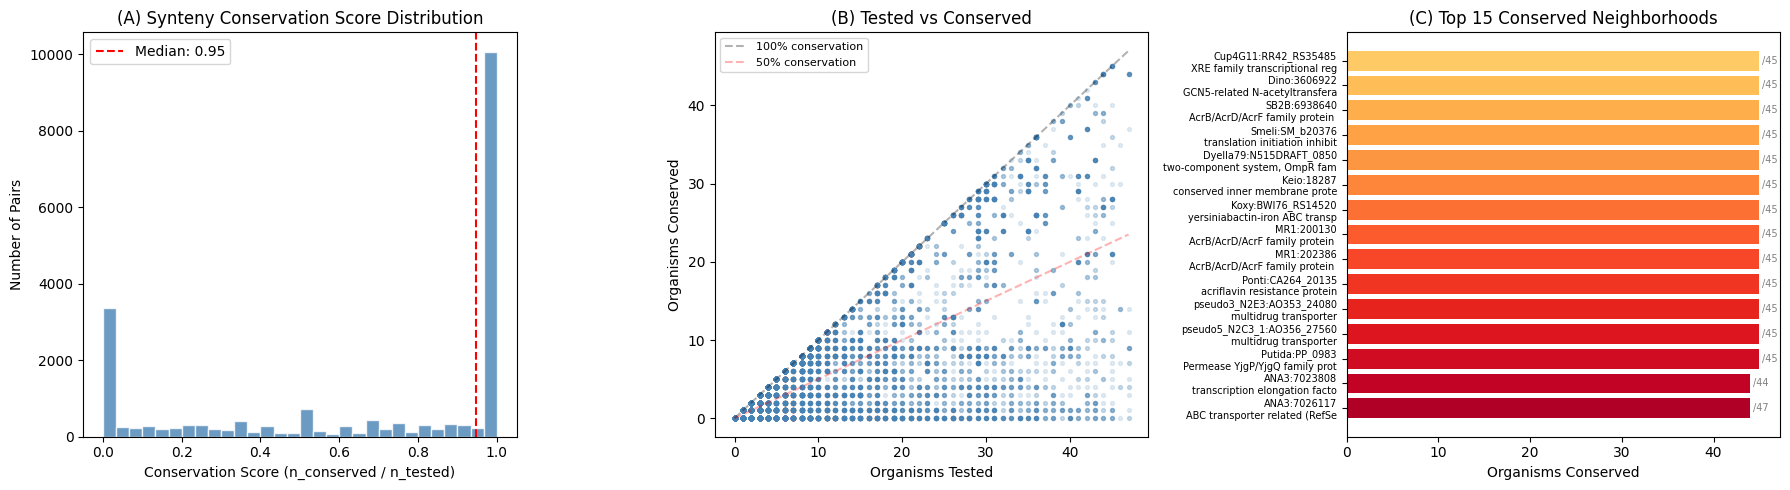

Saved: fig22_conserved_neighborhoods.png


In [9]:
# Figure 22: Conserved Gene Neighborhoods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (A) Conservation score histogram
ax = axes[0]
scored = synteny_df[synteny_df['n_tested'] > 0]
ax.hist(scored['conservation_score'], bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(scored['conservation_score'].median(), color='red', linestyle='--',
           label=f'Median: {scored["conservation_score"].median():.2f}')
ax.set_xlabel('Conservation Score (n_conserved / n_tested)')
ax.set_ylabel('Number of Pairs')
ax.set_title('(A) Synteny Conservation Score Distribution')
ax.legend()

# (B) n_tested vs n_conserved scatter
ax = axes[1]
ax.scatter(synteny_df['n_tested'], synteny_df['n_conserved'],
           alpha=0.15, s=8, color='steelblue')
# Add diagonal lines
max_val = max(synteny_df['n_tested'].max(), synteny_df['n_conserved'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='100% conservation')
ax.plot([0, max_val], [0, max_val*0.5], 'r--', alpha=0.3, label='50% conservation')
ax.set_xlabel('Organisms Tested')
ax.set_ylabel('Organisms Conserved')
ax.set_title('(B) Tested vs Conserved')
ax.legend(fontsize=8)

# (C) Top 15 most conserved pairs
ax = axes[2]
top15 = synteny_df.nlargest(15, 'n_conserved').copy()
top15['label'] = top15.apply(
    lambda r: f"{r['orgId']}:{r['dark_locusId']}\n{r['partner_desc'][:30]}" if pd.notna(r['partner_desc']) else f"{r['orgId']}:{r['dark_locusId']}",
    axis=1
)
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(top15)))
bars = ax.barh(range(len(top15)), top15['n_conserved'].values, color=colors)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['label'].values, fontsize=7)
ax.set_xlabel('Organisms Conserved')
ax.set_title('(C) Top 15 Conserved Neighborhoods')
ax.invert_yaxis()

# Add n_tested annotation
for i, (_, row) in enumerate(top15.iterrows()):
    ax.text(row['n_conserved'] + 0.3, i, f"/{row['n_tested']}",
            va='center', fontsize=7, color='gray')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig22_conserved_neighborhoods.png'), dpi=150, bbox_inches='tight')
plt.show()
plt.show()
print('Saved: fig22_conserved_neighborhoods.png')

---
## Section 2: Cofit-Validated Operons

**Strategy**: Check whether dark gene and operon partner are each other's cofit partners
(co-fitness = correlated fitness profiles across conditions).

**Scoring scheme**:
- Mutual top-5: 1.0 (both genes rank each other in top 5 cofit partners)
- One-directional top-5: 0.75 (one gene ranks the other in top 5)
- Mutual top-20 (cofit > 0.5): 0.5 (both rank each other in top 20)
- One-directional top-20: 0.25 (one gene ranks the other in top 20)

In [10]:
# Filter to cofit-testable pairs
# Essential genes have no genefitness rows -> no cofit data
# Check which dark genes in our operon pairs are essential
essential_dark_set = set(
    zip(dark_genes[dark_genes['is_essential_dark'] == True]['orgId'],
        dark_genes[dark_genes['is_essential_dark'] == True]['locusId'])
)

operon_pairs_df['is_essential_dark'] = operon_pairs_df.apply(
    lambda r: (r['orgId'], r['dark_locusId']) in essential_dark_set, axis=1
)

testable_pairs = operon_pairs_df[~operon_pairs_df['is_essential_dark']].copy()

print(f'Total operon pairs: {len(operon_pairs_df):,}')
print(f'Essential dark gene pairs (excluded): {operon_pairs_df["is_essential_dark"].sum():,}')
print(f'Cofit-testable pairs: {len(testable_pairs):,}')
print(f'Unique organisms with testable pairs: {testable_pairs["orgId"].nunique()}')

Total operon pairs: 38,264
Essential dark gene pairs (excluded): 6,189
Cofit-testable pairs: 32,075
Unique organisms with testable pairs: 48


In [11]:
# Query cofit table per organism
# For each organism with testable pairs, collect all relevant locusIds
# and query: SELECT locusId, hitId, CAST(cofit AS FLOAT), CAST(rank AS INT)
#            FROM cofit WHERE orgId='{org}' AND rank <= 20

cofit_hits = {}  # (orgId, locusId) -> list of (hitId, cofit, rank)

orgs_with_pairs = testable_pairs['orgId'].unique()
print(f'Querying cofit for {len(orgs_with_pairs)} organisms...')

for i, org in enumerate(orgs_with_pairs):
    # Get all relevant locusIds for this organism
    org_pairs = testable_pairs[testable_pairs['orgId'] == org]
    relevant_loci = set(org_pairs['dark_locusId'].tolist() + org_pairs['partner_locusId'].tolist())
    
    if not relevant_loci:
        continue
    
    # Create temp view with relevant locusIds
    loci_df = spark.createDataFrame([(l,) for l in relevant_loci], ['locusId'])
    loci_df.createOrReplaceTempView('_tmp_loci')
    
    # Query cofit table
    try:
        cofit_sdf = spark.sql(f"""
            SELECT c.locusId, c.hitId, CAST(c.cofit AS FLOAT) AS cofit, CAST(c.rank AS INT) AS rank
            FROM kescience_fitnessbrowser.cofit c
            INNER JOIN _tmp_loci t ON c.locusId = t.locusId
            WHERE c.orgId = '{org}' AND CAST(c.rank AS INT) <= 20
        """)
        cofit_pdf = cofit_sdf.toPandas()
        
        for _, row in cofit_pdf.iterrows():
            key = (org, row['locusId'])
            if key not in cofit_hits:
                cofit_hits[key] = []
            cofit_hits[key].append((row['hitId'], row['cofit'], row['rank']))
        
        if (i + 1) % 10 == 0:
            print(f'  {i+1}/{len(orgs_with_pairs)} organisms processed ({len(cofit_pdf)} rows for {org})')
    except Exception as e:
        print(f'  Warning: cofit query failed for {org}: {e}')

print(f'\nCofit data loaded for {len(cofit_hits):,} (org, locusId) combinations')

Querying cofit for 48 organisms...


  10/48 organisms processed (9840 rows for Dda3937)


  20/48 organisms processed (17440 rows for WCS417)


  30/48 organisms processed (8620 rows for Methanococcus_JJ)


  40/48 organisms processed (22260 rows for pseudo6_N2E2)



Cofit data loaded for 46,465 (org, locusId) combinations


In [12]:
# Score cofit validation for each testable pair
cofit_results = []

for _, pair in testable_pairs.iterrows():
    org = pair['orgId']
    dark_loc = pair['dark_locusId']
    partner_loc = pair['partner_locusId']
    
    # Forward: is partner in dark gene's cofit hits?
    dark_hits = cofit_hits.get((org, dark_loc), [])
    forward_hit = None
    for hit_id, cofit_val, rank in dark_hits:
        if hit_id == partner_loc:
            forward_hit = (cofit_val, rank)
            break
    
    # Reverse: is dark gene in partner's cofit hits?
    partner_hits = cofit_hits.get((org, partner_loc), [])
    reverse_hit = None
    for hit_id, cofit_val, rank in partner_hits:
        if hit_id == dark_loc:
            reverse_hit = (cofit_val, rank)
            break
    
    # Tiered scoring
    fwd_top5 = forward_hit is not None and forward_hit[1] <= 5
    rev_top5 = reverse_hit is not None and reverse_hit[1] <= 5
    fwd_top20 = forward_hit is not None
    rev_top20 = reverse_hit is not None
    fwd_high_cofit = forward_hit is not None and forward_hit[0] > 0.5
    rev_high_cofit = reverse_hit is not None and reverse_hit[0] > 0.5
    
    if fwd_top5 and rev_top5:
        cofit_score = 1.0
        cofit_tier = 'mutual_top5'
    elif fwd_top5 or rev_top5:
        cofit_score = 0.75
        cofit_tier = 'one_dir_top5'
    elif (fwd_top20 and rev_top20) and (fwd_high_cofit and rev_high_cofit):
        cofit_score = 0.5
        cofit_tier = 'mutual_top20_high'
    elif fwd_top20 or rev_top20:
        cofit_score = 0.25
        cofit_tier = 'one_dir_top20'
    else:
        cofit_score = 0.0
        cofit_tier = 'no_cofit'
    
    cofit_results.append({
        'orgId': org,
        'dark_locusId': dark_loc,
        'partner_locusId': partner_loc,
        'partner_desc': pair['partner_desc'],
        'forward_cofit': forward_hit[0] if forward_hit else np.nan,
        'forward_rank': forward_hit[1] if forward_hit else np.nan,
        'reverse_cofit': reverse_hit[0] if reverse_hit else np.nan,
        'reverse_rank': reverse_hit[1] if reverse_hit else np.nan,
        'cofit_score': cofit_score,
        'cofit_tier': cofit_tier
    })

cofit_df = pd.DataFrame(cofit_results)
cofit_df.to_csv(os.path.join(DATA_DIR, 'cofit_validated_operons.tsv'), sep='\t', index=False)

print(f'Cofit validation complete: {len(cofit_df):,} pairs scored')
print(f'\nSaved: cofit_validated_operons.tsv')
print(f'\nCofit tier distribution:')
print(cofit_df['cofit_tier'].value_counts())

Cofit validation complete: 32,075 pairs scored

Saved: cofit_validated_operons.tsv

Cofit tier distribution:
cofit_tier
no_cofit             29176
mutual_top5           1129
one_dir_top5           825
one_dir_top20          811
mutual_top20_high      134
Name: count, dtype: int64


In [13]:
# Aggregate per dark gene: max cofit score, n cofit-validated partners
cofit_agg = cofit_df[cofit_df['cofit_score'] > 0].groupby(['orgId', 'dark_locusId']).agg(
    max_cofit_score=('cofit_score', 'max'),
    mean_cofit_score=('cofit_score', 'mean'),
    n_cofit_validated=('cofit_score', 'count'),
    best_cofit_tier=('cofit_tier', 'first')  # from highest-scoring pair
).reset_index()

# Add best cofit partner info
cofit_validated = cofit_df[cofit_df['cofit_score'] > 0]
if len(cofit_validated) > 0:
    best_cofit = cofit_validated.loc[
        cofit_validated.groupby(['orgId', 'dark_locusId'])['cofit_score'].idxmax()
    ][['orgId', 'dark_locusId', 'partner_locusId', 'partner_desc']].rename(
        columns={'partner_locusId': 'best_cofit_partner', 'partner_desc': 'best_cofit_partner_desc'}
    )
    cofit_agg = cofit_agg.merge(best_cofit, on=['orgId', 'dark_locusId'], how='left')

print(f'Dark genes with any cofit validation: {len(cofit_agg):,}')
print(f'\nMax cofit score distribution:')
print(cofit_agg['max_cofit_score'].describe())

# How many in each tier
print(f'\nDark genes by best cofit tier:')
print(cofit_agg['best_cofit_tier'].value_counts())

Dark genes with any cofit validation: 2,594

Max cofit score distribution:
count    2594.000000
mean        0.701715
std         0.307942
min         0.250000
25%         0.250000
50%         0.750000
75%         1.000000
max         1.000000
Name: max_cofit_score, dtype: float64

Dark genes by best cofit tier:
best_cofit_tier
mutual_top5          987
one_dir_top20        752
one_dir_top5         748
mutual_top20_high    107
Name: count, dtype: int64


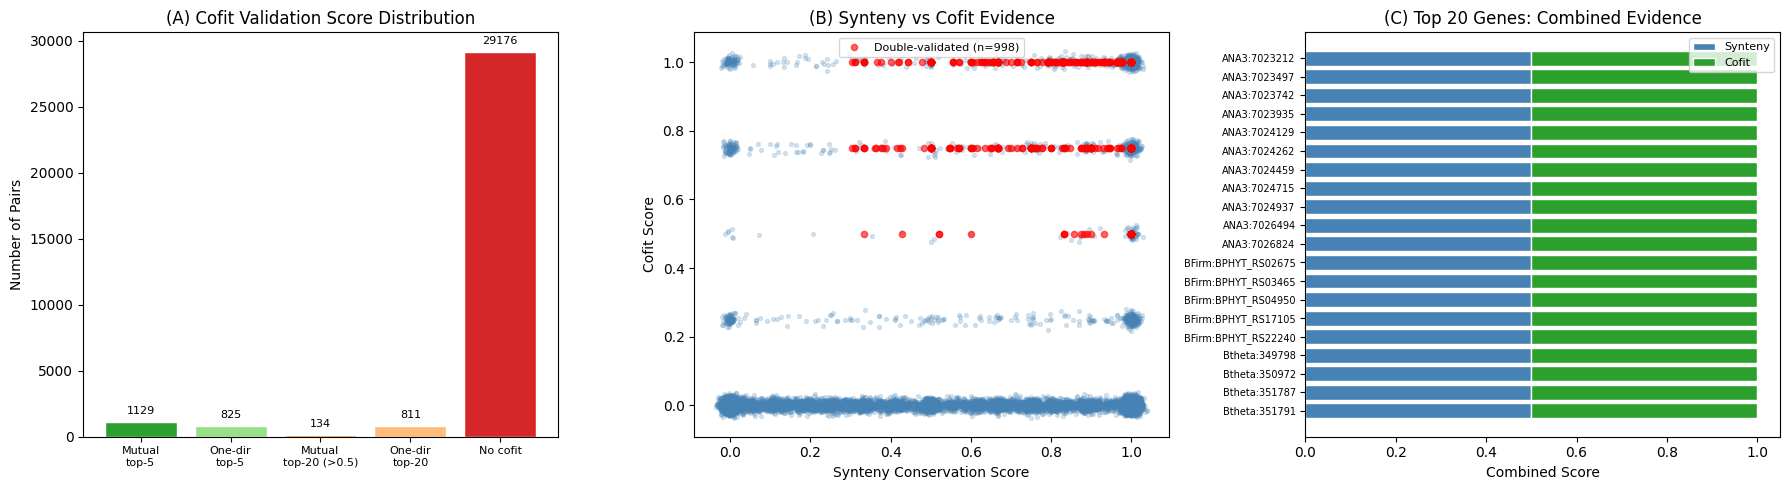

Saved: fig23_cofit_validation.png


In [14]:
# Figure 23: Cofit Validation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (A) Score distribution bar chart
ax = axes[0]
tier_order = ['mutual_top5', 'one_dir_top5', 'mutual_top20_high', 'one_dir_top20', 'no_cofit']
tier_labels = ['Mutual\ntop-5', 'One-dir\ntop-5', 'Mutual\ntop-20 (>0.5)', 'One-dir\ntop-20', 'No cofit']
tier_colors = ['#2ca02c', '#98df8a', '#ff7f0e', '#ffbb78', '#d62728']
tier_counts = cofit_df['cofit_tier'].value_counts()
counts = [tier_counts.get(t, 0) for t in tier_order]
ax.bar(range(len(tier_order)), counts, color=tier_colors, edgecolor='white')
ax.set_xticks(range(len(tier_order)))
ax.set_xticklabels(tier_labels, fontsize=8)
ax.set_ylabel('Number of Pairs')
ax.set_title('(A) Cofit Validation Score Distribution')
for i, c in enumerate(counts):
    ax.text(i, c + max(counts)*0.02, str(c), ha='center', fontsize=8)

# (B) Scatter of cofit vs synteny score
ax = axes[1]
# Merge cofit and synteny on pair keys
merged = cofit_df.merge(
    synteny_df[['orgId', 'dark_locusId', 'partner_locusId', 'conservation_score']],
    on=['orgId', 'dark_locusId', 'partner_locusId'],
    how='inner'
)
if len(merged) > 0:
    # Add jitter to avoid overplotting
    jitter_x = np.random.normal(0, 0.01, len(merged))
    jitter_y = np.random.normal(0, 0.01, len(merged))
    ax.scatter(merged['conservation_score'] + jitter_x,
              merged['cofit_score'] + jitter_y,
              alpha=0.2, s=8, color='steelblue')
    # Highlight double-validated
    double_val = merged[(merged['conservation_score'] > 0.3) & (merged['cofit_score'] >= 0.5)]
    ax.scatter(double_val['conservation_score'], double_val['cofit_score'],
              alpha=0.6, s=20, color='red', label=f'Double-validated (n={len(double_val)})')
    ax.legend(fontsize=8)
ax.set_xlabel('Synteny Conservation Score')
ax.set_ylabel('Cofit Score')
ax.set_title('(B) Synteny vs Cofit Evidence')

# (C) Top 20 genes with strongest combined evidence
ax = axes[2]
# Compute combined score per dark gene
combined = synteny_agg.merge(cofit_agg, on=['orgId', 'dark_locusId'], how='outer')
combined['max_conservation_score'] = combined['max_conservation_score'].fillna(0)
combined['max_cofit_score'] = combined['max_cofit_score'].fillna(0)
combined['combined_score'] = combined['max_conservation_score'] * 0.5 + combined['max_cofit_score'] * 0.5
top20_combined = combined.nlargest(20, 'combined_score')

# Stacked bar: synteny (blue) + cofit (green)
y_pos = range(len(top20_combined))
labels = [f"{r['orgId']}:{r['dark_locusId']}" for _, r in top20_combined.iterrows()]
ax.barh(y_pos, top20_combined['max_conservation_score'].values * 0.5,
        color='steelblue', label='Synteny', edgecolor='white')
ax.barh(y_pos, top20_combined['max_cofit_score'].values * 0.5,
        left=top20_combined['max_conservation_score'].values * 0.5,
        color='#2ca02c', label='Cofit', edgecolor='white')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel('Combined Score')
ax.set_title('(C) Top 20 Genes: Combined Evidence')
ax.invert_yaxis()
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig23_cofit_validation.png'), dpi=150, bbox_inches='tight')
plt.show()
plt.show()
print('Saved: fig23_cofit_validation.png')

---
## Section 3: Cross-Check & Improved Prioritization

1. Cross-check top candidates against Paramvir Dehal's prior module-based predictions
2. Merge synteny + cofit evidence into scoring
3. Re-rank candidates with improved scores
4. Build evidence-weighted experimental roadmap

In [15]:
# Cross-check against Paramvir's predictions
# all_predictions_summary.csv: orgId, locusId, predicted_function, prediction_source, confidence
# essential_predictions.tsv: target_orgId, target_locusId, predicted_term, confidence

pred_lookup = {}
for _, row in predictions.iterrows():
    pred_lookup[(row['orgId'], row['locusId'])] = {
        'predicted_function': row.get('predicted_function', ''),
        'prediction_source': row.get('prediction_source', ''),
        'confidence': row.get('confidence', 0),
        'predicted_function_desc': row.get('predicted_function_desc', '')
    }

ess_pred_lookup = {}
for _, row in ess_preds.iterrows():
    ess_pred_lookup[(row['target_orgId'], row['target_locusId'])] = {
        'predicted_term': row.get('predicted_term', ''),
        'confidence': row.get('confidence', 0),
        'source_module': row.get('source_module', '')
    }

# Check top-100 fitness-active candidates
print('=== Top-100 Fitness-Active Candidates vs Paramvir\'s Predictions ===')
n_with_pred = 0
n_agree = 0
n_disagree = 0
n_no_pred = 0

cross_check_rows = []
for _, row in top100.iterrows():
    key = (row['orgId'], row['locusId'])
    pred = pred_lookup.get(key)
    ess_pred = ess_pred_lookup.get(key)
    
    has_pred = pred is not None or ess_pred is not None
    if has_pred:
        n_with_pred += 1
        # Check if our module_prediction matches
        our_pred = str(row.get('module_prediction', ''))
        their_pred = pred['predicted_function'] if pred else (ess_pred['predicted_term'] if ess_pred else '')
        if our_pred and their_pred and our_pred == their_pred:
            n_agree += 1
            status = 'AGREE'
        elif our_pred and their_pred:
            n_disagree += 1
            status = 'DIFFER'
        else:
            status = 'PARTIAL'
    else:
        n_no_pred += 1
        status = 'NO_PRIOR'
    
    cross_check_rows.append({
        'orgId': row['orgId'],
        'locusId': row['locusId'],
        'our_prediction': row.get('module_prediction', ''),
        'paramvir_prediction': pred['predicted_function'] if pred else (ess_pred['predicted_term'] if ess_pred else ''),
        'status': status
    })

print(f'  With prior prediction: {n_with_pred}/100')
print(f'  Agree: {n_agree}')
print(f'  Differ: {n_disagree}')
print(f'  No prior prediction: {n_no_pred}')

# Check top-50 essential candidates
print(f'\n=== Top-50 Essential Dark Candidates vs Paramvir\'s Predictions ===')
n_ess_with_pred = 0
for _, row in ess_top50.iterrows():
    key = (row['orgId'], row['locusId'])
    if key in pred_lookup or key in ess_pred_lookup:
        n_ess_with_pred += 1

print(f'  With prior prediction: {n_ess_with_pred}/50')

cross_check_df = pd.DataFrame(cross_check_rows)
print(f'\nCross-check status distribution:')
print(cross_check_df['status'].value_counts())

=== Top-100 Fitness-Active Candidates vs Paramvir's Predictions ===
  With prior prediction: 85/100
  Agree: 85
  Differ: 0
  No prior prediction: 15

=== Top-50 Essential Dark Candidates vs Paramvir's Predictions ===
  With prior prediction: 38/50

Cross-check status distribution:
status
AGREE       85
NO_PRIOR    15
Name: count, dtype: int64


In [16]:
# Merge new evidence into scoring
# For fitness-active genes: synteny/cofit improve the s_inference dimension
# For essential genes: they improve the s_neighbor dimension

# --- Fitness-active scoring update ---
scoring_active_new = scoring_active.copy()

# Left-join synteny aggregates
scoring_active_new = scoring_active_new.merge(
    synteny_agg[['orgId', 'dark_locusId', 'max_conservation_score', 'total_conserved_instances']].rename(
        columns={'dark_locusId': 'locusId'}
    ),
    on=['orgId', 'locusId'], how='left'
)

# Left-join cofit aggregates
scoring_active_new = scoring_active_new.merge(
    cofit_agg[['orgId', 'dark_locusId', 'max_cofit_score', 'n_cofit_validated']].rename(
        columns={'dark_locusId': 'locusId'}
    ),
    on=['orgId', 'locusId'], how='left'
)

scoring_active_new['max_conservation_score'] = scoring_active_new['max_conservation_score'].fillna(0)
scoring_active_new['max_cofit_score'] = scoring_active_new['max_cofit_score'].fillna(0)

# Update s_inference: add up to 0.15 for synteny + 0.15 for cofit (capped at 1.0)
scoring_active_new['s_inference_original'] = scoring_active_new['s_inference']
scoring_active_new['s_inference'] = np.minimum(
    scoring_active_new['s_inference']
    + scoring_active_new['max_conservation_score'] * 0.15  # up to 0.15 boost
    + scoring_active_new['max_cofit_score'] * 0.15,  # up to 0.15 boost
    1.0
)

# Recompute total score (same weights as NB05)
scoring_active_new['total_score_original'] = scoring_active_new['total_score']
scoring_active_new['total_score'] = (
    scoring_active_new['s_fitness'] * 0.25
    + scoring_active_new['s_conservation'] * 0.20
    + scoring_active_new['s_inference'] * 0.20
    + scoring_active_new['s_pangenome'] * 0.15
    + scoring_active_new['s_biogeographic'] * 0.10
    + scoring_active_new['s_tractability'] * 0.10
)

# --- Essential gene scoring update ---
scoring_ess_new = scoring_essential.copy()

scoring_ess_new = scoring_ess_new.merge(
    synteny_agg[['orgId', 'dark_locusId', 'max_conservation_score', 'total_conserved_instances']].rename(
        columns={'dark_locusId': 'locusId'}
    ),
    on=['orgId', 'locusId'], how='left'
)
scoring_ess_new = scoring_ess_new.merge(
    cofit_agg[['orgId', 'dark_locusId', 'max_cofit_score', 'n_cofit_validated']].rename(
        columns={'dark_locusId': 'locusId'}
    ),
    on=['orgId', 'locusId'], how='left'
)

scoring_ess_new['max_conservation_score'] = scoring_ess_new['max_conservation_score'].fillna(0)
scoring_ess_new['max_cofit_score'] = scoring_ess_new['max_cofit_score'].fillna(0)

# Update s_neighbor: add up to 0.1 for synteny (essential genes mostly lack cofit)
scoring_ess_new['s_neighbor_original'] = scoring_ess_new['s_neighbor']
scoring_ess_new['s_neighbor'] = np.minimum(
    scoring_ess_new['s_neighbor'] + scoring_ess_new['max_conservation_score'] * 0.1,
    1.0
)

# Recompute total (same weights as NB07)
scoring_ess_new['total_score_original'] = scoring_ess_new['total_score']
scoring_ess_new['total_score'] = (
    scoring_ess_new['s_neighbor'] * 0.25
    + scoring_ess_new['s_conservation'] * 0.20
    + scoring_ess_new['s_breadth'] * 0.20
    + scoring_ess_new['s_domains'] * 0.15
    + scoring_ess_new['s_tractability'] * 0.20
)

# Re-rank
scoring_active_new = scoring_active_new.sort_values('total_score', ascending=False).reset_index(drop=True)
scoring_active_new['new_rank'] = range(1, len(scoring_active_new) + 1)

scoring_ess_new = scoring_ess_new.sort_values('total_score', ascending=False).reset_index(drop=True)
scoring_ess_new['new_rank'] = range(1, len(scoring_ess_new) + 1)

print('=== Fitness-Active Scoring Update ===')
n_boosted = (scoring_active_new['total_score'] > scoring_active_new['total_score_original']).sum()
print(f'Genes with score boost: {n_boosted:,} / {len(scoring_active_new):,}')
print(f'Mean score change: {(scoring_active_new["total_score"] - scoring_active_new["total_score_original"]).mean():.4f}')
print(f'Max score change: {(scoring_active_new["total_score"] - scoring_active_new["total_score_original"]).max():.4f}')

print(f'\n=== Essential Gene Scoring Update ===')
n_ess_boosted = (scoring_ess_new['total_score'] > scoring_ess_new['total_score_original']).sum()
print(f'Genes with score boost: {n_ess_boosted:,} / {len(scoring_ess_new):,}')
print(f'Mean score change: {(scoring_ess_new["total_score"] - scoring_ess_new["total_score_original"]).mean():.4f}')

=== Fitness-Active Scoring Update ===
Genes with score boost: 10,857 / 17,344
Mean score change: 0.0076
Max score change: 0.0600

=== Essential Gene Scoring Update ===
Genes with score boost: 4,028 / 9,557
Mean score change: 0.0047


In [17]:
# Print improved top-20 candidates (fitness-active + essential) with rank changes

# Build original rank lookup
orig_active_ranks = scoring_active.sort_values('total_score', ascending=False).reset_index(drop=True)
orig_active_ranks['orig_rank'] = range(1, len(orig_active_ranks) + 1)
orig_rank_lookup = dict(zip(
    zip(orig_active_ranks['orgId'], orig_active_ranks['locusId']),
    orig_active_ranks['orig_rank']
))

orig_ess_ranks = scoring_essential.sort_values('total_score', ascending=False).reset_index(drop=True)
orig_ess_ranks['orig_rank'] = range(1, len(orig_ess_ranks) + 1)
orig_ess_rank_lookup = dict(zip(
    zip(orig_ess_ranks['orgId'], orig_ess_ranks['locusId']),
    orig_ess_ranks['orig_rank']
))

print('=== Improved Top-20 Fitness-Active Candidates ===')
print(f'{"Rank":>4} {"Old":>4} {"Change":>6}  {"Org":20} {"Locus":15} {"Score":>7} {"Old":>7} {"Synteny":>7} {"Cofit":>7}')
print('-' * 100)
for _, row in scoring_active_new.head(20).iterrows():
    orig_rank = orig_rank_lookup.get((row['orgId'], row['locusId']), '?')
    rank_change = orig_rank - row['new_rank'] if isinstance(orig_rank, int) else 0
    change_str = f'+{rank_change}' if rank_change > 0 else str(rank_change)
    print(f"{row['new_rank']:4d} {orig_rank:>4} {change_str:>6}  {row['orgId']:20} {row['locusId']:15} "
          f"{row['total_score']:7.4f} {row['total_score_original']:7.4f} "
          f"{row['max_conservation_score']:7.3f} {row['max_cofit_score']:7.3f}")

print(f'\n=== Improved Top-20 Essential Dark Candidates ===')
print(f'{"Rank":>4} {"Old":>4} {"Change":>6}  {"Org":20} {"Locus":15} {"Score":>7} {"Old":>7} {"Synteny":>7}')
print('-' * 90)
for _, row in scoring_ess_new.head(20).iterrows():
    orig_rank = orig_ess_rank_lookup.get((row['orgId'], row['locusId']), '?')
    rank_change = orig_rank - row['new_rank'] if isinstance(orig_rank, int) else 0
    change_str = f'+{rank_change}' if rank_change > 0 else str(rank_change)
    print(f"{row['new_rank']:4d} {orig_rank:>4} {change_str:>6}  {row['orgId']:20} {row['locusId']:15} "
          f"{row['total_score']:7.4f} {row['total_score_original']:7.4f} "
          f"{row['max_conservation_score']:7.3f}")

=== Improved Top-20 Fitness-Active Candidates ===
Rank  Old Change  Org                  Locus             Score     Old Synteny   Cofit
----------------------------------------------------------------------------------------------------
   1    9     +8  pseudo5_N2C3_1       AO356_15270      0.7450  0.6850   1.000   1.000
   2   17    +15  Marino               GFF1367          0.7325  0.6725   1.000   1.000
   3   19    +16  pseudo5_N2C3_1       AO356_17245      0.7311  0.6711   1.000   1.000
   4    8     +4  MR1                  201124           0.7260  0.6850   0.367   1.000
   5   22    +17  MR1                  203631           0.7258  0.6658   1.000   1.000
   6    4     -2  MR1                  203545           0.7245  0.6945   1.000   0.000
   7   20    +13  pseudo5_N2C3_1       AO356_08210      0.7227  0.6702   1.000   0.750
   8   26    +18  MR1                  202608           0.7225  0.6625   1.000   1.000
   9   29    +20  MR1                  202208           0.7193  0.

In [18]:
# Build experimental roadmap
# Combine top-200 fitness-active + top-100 essential candidates
# For each (organism, condition): n_candidates_addressed, sum_improved_scores, phylo_gap_bonus

top200_active = scoring_active_new.head(200).copy()
top100_ess = scoring_ess_new.head(100).copy()

# Phylogenetic gap bonus: reward experiments in under-represented phyla
# Use dark_genes_integrated for taxonomy info
org_phyla = dark_genes[['orgId', 'gtdb_species_clade_id']].drop_duplicates()
org_phyla_map = dict(zip(org_phyla['orgId'], org_phyla['gtdb_species_clade_id']))

# Count candidates per organism
active_per_org = top200_active.groupby('orgId').agg(
    n_active=('locusId', 'count'),
    sum_active_score=('total_score', 'sum'),
    top_conditions=('top_condition_class', lambda x: '; '.join(x.value_counts().head(3).index.tolist()))
).reset_index()

ess_per_org = top100_ess.groupby('orgId').agg(
    n_essential=('locusId', 'count'),
    sum_ess_score=('total_score', 'sum')
).reset_index()

# Merge
roadmap = active_per_org.merge(ess_per_org, on='orgId', how='outer').fillna(0)
roadmap['n_active'] = roadmap['n_active'].astype(int)
roadmap['n_essential'] = roadmap['n_essential'].astype(int)
roadmap['n_total_candidates'] = roadmap['n_active'] + roadmap['n_essential']
roadmap['total_evidence_score'] = roadmap['sum_active_score'] + roadmap['sum_ess_score']

# Determine experiment type
roadmap['experiment_type'] = roadmap.apply(
    lambda r: 'RB-TnSeq + CRISPRi' if r['n_active'] > 0 and r['n_essential'] > 0
    else ('CRISPRi' if r['n_essential'] > 0 else 'RB-TnSeq'), axis=1
)

# Phylogenetic gap bonus
# Organisms with fewer total experiments in FB get a bonus
org_experiment_counts = dark_genes.groupby('orgId')['n_experiments'].first().to_dict()
phyla_counts = Counter(org_phyla_map.values())
roadmap['phylo_gap_bonus'] = roadmap['orgId'].apply(
    lambda o: 1.0 / np.log2(max(phyla_counts.get(org_phyla_map.get(o, ''), 1), 2))
)

# Add synteny/cofit evidence counts — filtered to top candidates only
candidate_loci = set(zip(top200_active['orgId'], top200_active['locusId'])) | \
                 set(zip(top100_ess['orgId'], top100_ess['locusId']))
syn_candidates = synteny_df[(synteny_df['n_conserved'] > 0) &
    synteny_df.apply(lambda r: (r['orgId'], r['dark_locusId']) in candidate_loci, axis=1)]
cof_candidates = cofit_df[(cofit_df['cofit_score'] > 0) &
    cofit_df.apply(lambda r: (r['orgId'], r['dark_locusId']) in candidate_loci, axis=1)]
synteny_per_org = syn_candidates.groupby('orgId').size().to_dict()
cofit_per_org = cof_candidates.groupby('orgId').size().to_dict()
roadmap['n_synteny_validated'] = roadmap['orgId'].map(synteny_per_org).fillna(0).astype(int)
roadmap['n_cofit_validated'] = roadmap['orgId'].map(cofit_per_org).fillna(0).astype(int)

# Final priority score: evidence-weighted
roadmap['priority_score'] = (
    roadmap['total_evidence_score']
    + roadmap['n_synteny_validated'] * 0.5
    + roadmap['n_cofit_validated'] * 0.5
    + roadmap['phylo_gap_bonus'] * 2
)
roadmap = roadmap.sort_values('priority_score', ascending=False).reset_index(drop=True)
roadmap['experiment_rank'] = range(1, len(roadmap) + 1)

# Save
roadmap.to_csv(os.path.join(DATA_DIR, 'experimental_roadmap.tsv'), sep='\t', index=False)
print(f'Experimental roadmap: {len(roadmap)} organisms')
print(f'Saved: experimental_roadmap.tsv')
print(f'\nTop 15 experiments:')
print(roadmap[['experiment_rank', 'orgId', 'n_total_candidates', 'n_synteny_validated',
               'n_cofit_validated', 'experiment_type', 'priority_score']].head(15).to_string(index=False))

Experimental roadmap: 30 organisms
Saved: experimental_roadmap.tsv

Top 15 experiments:
 experiment_rank              orgId  n_total_candidates  n_synteny_validated  n_cofit_validated    experiment_type  priority_score
               1                MR1                  66                   93                 31 RB-TnSeq + CRISPRi      108.895593
               2     pseudo5_N2C3_1                  35                   51                 23 RB-TnSeq + CRISPRi       62.021125
               3             Putida                  23                   34                 11 RB-TnSeq + CRISPRi       40.217991
               4             Marino                  23                   28                 10 RB-TnSeq + CRISPRi       36.896834
               5       pseudo1_N1B4                  20                   29                  9 RB-TnSeq + CRISPRi       34.188697
               6               Keio                  21                   25                  5 RB-TnSeq + CRISPRi       32.44

In [19]:
# Save improved candidates
# Combine top-200 active + top-100 essential with new scores

improved_active = top200_active[[
    'orgId', 'locusId', 'desc', 'annotation_class', 'max_abs_fit',
    'top_condition_class', 'module_prediction', 'OG_id', 'og_n_organisms',
    'n_domains', 'domain_names',
    's_fitness', 's_conservation', 's_inference', 's_inference_original',
    's_pangenome', 's_biogeographic', 's_tractability',
    'total_score', 'total_score_original', 'new_rank',
    'max_conservation_score', 'max_cofit_score'
]].copy()
improved_active['candidate_type'] = 'fitness_active'

improved_ess = top100_ess.copy()
# Ensure matching columns exist
for col in ['max_abs_fit', 'top_condition_class', 'module_prediction', 'OG_id',
            'og_n_organisms', 's_fitness', 's_pangenome', 's_biogeographic',
            's_inference', 's_inference_original']:
    if col not in improved_ess.columns:
        improved_ess[col] = np.nan
improved_ess['candidate_type'] = 'essential'

# Select compatible columns and combine
shared_cols = ['orgId', 'locusId', 'desc', 'annotation_class',
               'total_score', 'total_score_original', 'new_rank',
               'max_conservation_score', 'max_cofit_score', 'candidate_type']

improved_all = pd.concat([
    improved_active[shared_cols],
    improved_ess[shared_cols]
], ignore_index=True)

improved_all.to_csv(os.path.join(DATA_DIR, 'improved_candidates.tsv'), sep='\t', index=False)
print(f'Saved: improved_candidates.tsv ({len(improved_all)} rows)')
print(f'  Fitness-active: {(improved_all["candidate_type"] == "fitness_active").sum()}')
print(f'  Essential: {(improved_all["candidate_type"] == "essential").sum()}')

Saved: improved_candidates.tsv (300 rows)
  Fitness-active: 200
  Essential: 100


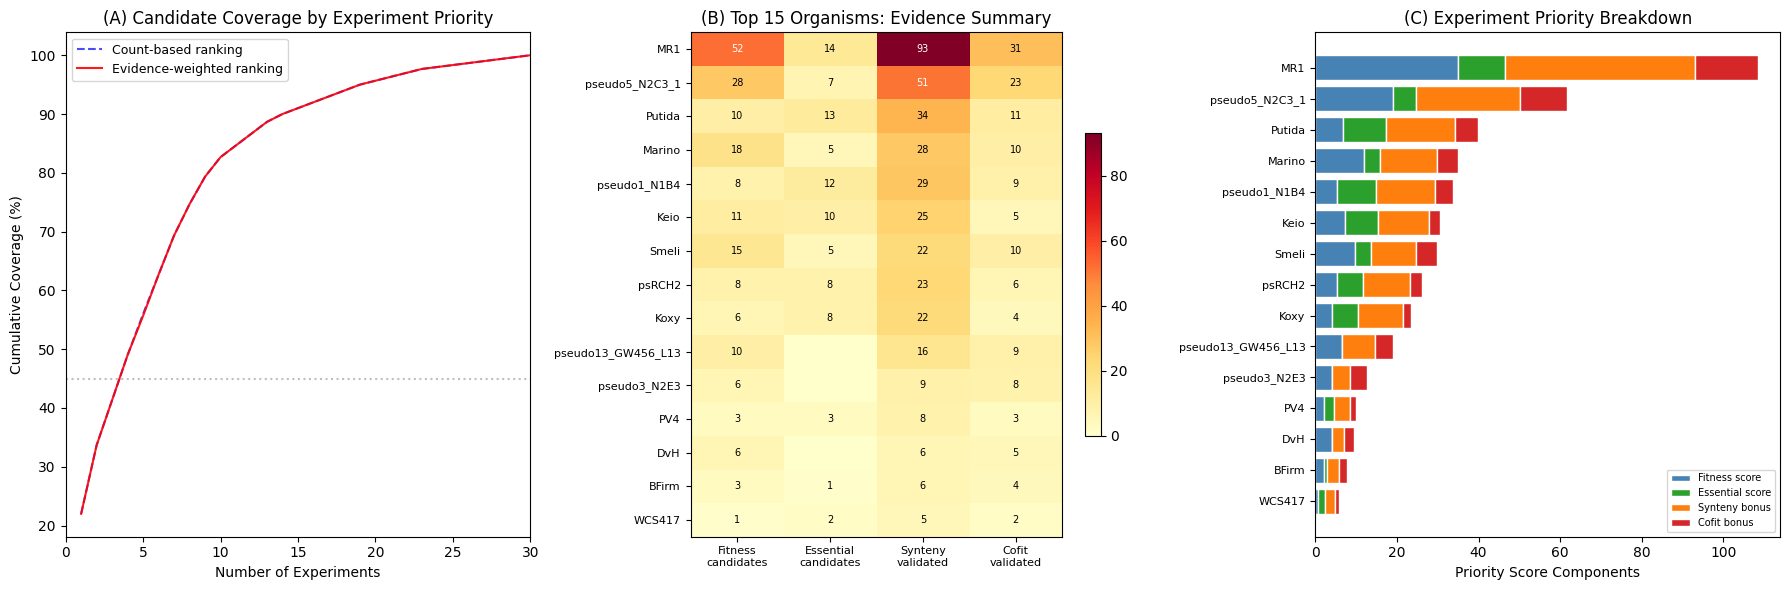

Saved: fig24_improved_experimental_roadmap.png


In [20]:
# Figure 24: Improved Experimental Roadmap
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (A) Cumulative coverage curve
ax = axes[0]
# Old roadmap: just by n_total_candidates descending
old_order = roadmap.sort_values('n_total_candidates', ascending=False)
old_cumulative = old_order['n_total_candidates'].cumsum().values
# New roadmap: by priority_score descending (already sorted)
new_cumulative = roadmap['n_total_candidates'].cumsum().values
total_candidates = roadmap['n_total_candidates'].sum()

ax.plot(range(1, len(old_cumulative)+1), old_cumulative / total_candidates * 100,
        'b--', alpha=0.7, label='Count-based ranking')
ax.plot(range(1, len(new_cumulative)+1), new_cumulative / total_candidates * 100,
        'r-', alpha=0.9, label='Evidence-weighted ranking')
ax.axhline(45, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Number of Experiments')
ax.set_ylabel('Cumulative Coverage (%)')
ax.set_title('(A) Candidate Coverage by Experiment Priority')
ax.legend(fontsize=9)
ax.set_xlim(0, min(len(roadmap), 30))

# (B) Organism heatmap (top 15 organisms)
ax = axes[1]
top15_roadmap = roadmap.head(15)
heatmap_data = top15_roadmap[['n_active', 'n_essential', 'n_synteny_validated', 'n_cofit_validated']].values
im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax.set_yticks(range(len(top15_roadmap)))
ax.set_yticklabels(top15_roadmap['orgId'].values, fontsize=8)
ax.set_xticks(range(4))
ax.set_xticklabels(['Fitness\ncandidates', 'Essential\ncandidates',
                     'Synteny\nvalidated', 'Cofit\nvalidated'], fontsize=8)
ax.set_title('(B) Top 15 Organisms: Evidence Summary')
# Add text annotations
for i in range(len(top15_roadmap)):
    for j in range(4):
        val = int(heatmap_data[i, j])
        if val > 0:
            ax.text(j, i, str(val), ha='center', va='center', fontsize=7,
                    color='white' if val > heatmap_data.max()/2 else 'black')
plt.colorbar(im, ax=ax, shrink=0.6)

# (C) Evidence tier breakdown
ax = axes[2]
top15_roadmap = roadmap.head(15).copy()
# Stacked bar: active (blue), essential (green), synteny bonus (orange), cofit bonus (red)
y_pos = range(len(top15_roadmap))
bar1 = ax.barh(y_pos, top15_roadmap['sum_active_score'].values,
               color='steelblue', label='Fitness score', edgecolor='white')
bar2 = ax.barh(y_pos, top15_roadmap['sum_ess_score'].values,
               left=top15_roadmap['sum_active_score'].values,
               color='#2ca02c', label='Essential score', edgecolor='white')
bar3 = ax.barh(y_pos, top15_roadmap['n_synteny_validated'].values * 0.5,
               left=(top15_roadmap['sum_active_score'] + top15_roadmap['sum_ess_score']).values,
               color='#ff7f0e', label='Synteny bonus', edgecolor='white')
bar4 = ax.barh(y_pos, top15_roadmap['n_cofit_validated'].values * 0.5,
               left=(top15_roadmap['sum_active_score'] + top15_roadmap['sum_ess_score'] +
                     top15_roadmap['n_synteny_validated'] * 0.5).values,
               color='#d62728', label='Cofit bonus', edgecolor='white')

ax.set_yticks(y_pos)
ax.set_yticklabels(top15_roadmap['orgId'].values, fontsize=8)
ax.set_xlabel('Priority Score Components')
ax.set_title('(C) Experiment Priority Breakdown')
ax.invert_yaxis()
ax.legend(fontsize=7, loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig24_improved_experimental_roadmap.png'), dpi=150, bbox_inches='tight')
plt.show()
plt.show()
print('Saved: fig24_improved_experimental_roadmap.png')

In [21]:
# Summary statistics
print('=' * 70)
print('NB08 SUMMARY: Conserved Neighborhoods, Cofit Validation & Improved Prioritization')
print('=' * 70)

print(f'\n--- Section 1: Conserved Gene Neighborhoods ---')
print(f'Operon pairs re-derived:           {len(operon_pairs_df):,}')
print(f'Pairs with both OGs (testable):    {n_both_og:,}')
print(f'Pairs conserved in >= 1 organism:   {(synteny_df["n_conserved"] >= 1).sum():,}')
print(f'Pairs conserved in >= 3 organisms:  {(synteny_df["n_conserved"] >= 3).sum():,}')
print(f'Pairs conserved in >= 5 organisms:  {(synteny_df["n_conserved"] >= 5).sum():,}')
print(f'Pairs conserved in >= 10 organisms: {(synteny_df["n_conserved"] >= 10).sum():,}')
print(f'Median conservation score:          {synteny_df[synteny_df["n_tested"]>0]["conservation_score"].median():.3f}')

print(f'\n--- Section 2: Cofit-Validated Operons ---')
print(f'Cofit-testable pairs:              {len(cofit_df):,}')
tier_counts = cofit_df['cofit_tier'].value_counts()
print(f'Mutual top-5:                      {tier_counts.get("mutual_top5", 0):,}')
print(f'One-directional top-5:             {tier_counts.get("one_dir_top5", 0):,}')
print(f'Mutual top-20 (high cofit):        {tier_counts.get("mutual_top20_high", 0):,}')
print(f'One-directional top-20:            {tier_counts.get("one_dir_top20", 0):,}')
print(f'Any cofit validation:              {(cofit_df["cofit_score"] > 0).sum():,}')

if len(merged) > 0:
    double_val = merged[(merged['conservation_score'] > 0.3) & (merged['cofit_score'] >= 0.5)]
    print(f'Double-validated (synteny>0.3 & cofit>=0.5): {len(double_val):,}')

print(f'\n--- Section 3: Improved Prioritization ---')
print(f'Fitness-active genes boosted:      {n_boosted:,} / {len(scoring_active_new):,}')
print(f'Essential genes boosted:           {n_ess_boosted:,} / {len(scoring_ess_new):,}')
print(f'Cross-check: {n_with_pred}/100 top candidates have prior predictions')
print(f'  Agree: {n_agree}, Differ: {n_disagree}')

print(f'\n--- Section 4: Experimental Roadmap ---')
print(f'Organisms in roadmap:              {len(roadmap)}')
top_org = roadmap.iloc[0]
print(f'Top organism: {top_org["orgId"]} ({top_org["n_total_candidates"]} candidates, score={top_org["priority_score"]:.1f})')
n_experiments_45pct = 0
running_total = 0
for _, r in roadmap.iterrows():
    running_total += r['n_total_candidates']
    n_experiments_45pct += 1
    if running_total / total_candidates >= 0.45:
        break
print(f'Experiments for 45% coverage:      {n_experiments_45pct}')

print(f'\n--- Output Files ---')
for fname in ['conserved_neighborhoods.tsv', 'cofit_validated_operons.tsv',
              'improved_candidates.tsv', 'experimental_roadmap.tsv']:
    fpath = os.path.join(DATA_DIR, fname)
    if os.path.exists(fpath):
        size = os.path.getsize(fpath)
        print(f'  {fname}: {size/1024:.0f} KB')

for fname in ['fig22_conserved_neighborhoods.png', 'fig23_cofit_validation.png',
              'fig24_improved_experimental_roadmap.png']:
    fpath = os.path.join(FIG_DIR, fname)
    if os.path.exists(fpath):
        print(f'  {fname}: OK')

print('\n' + '=' * 70)

NB08 SUMMARY: Conserved Neighborhoods, Cofit Validation & Improved Prioritization

--- Section 1: Conserved Gene Neighborhoods ---
Operon pairs re-derived:           38,264
Pairs with both OGs (testable):    21,011
Pairs conserved in >= 1 organism:   17,058
Pairs conserved in >= 3 organisms:  10,150
Pairs conserved in >= 5 organisms:  6,697
Pairs conserved in >= 10 organisms: 2,926
Median conservation score:          0.947

--- Section 2: Cofit-Validated Operons ---
Cofit-testable pairs:              32,075
Mutual top-5:                      1,129
One-directional top-5:             825
Mutual top-20 (high cofit):        134
One-directional top-20:            811
Any cofit validation:              2,899
Double-validated (synteny>0.3 & cofit>=0.5): 998

--- Section 3: Improved Prioritization ---
Fitness-active genes boosted:      10,857 / 17,344
Essential genes boosted:           4,028 / 9,557
Cross-check: 85/100 top candidates have prior predictions
  Agree: 85, Differ: 0

--- Section 4

In [22]:
# Print REPORT.md additions

# Count key numbers for report text
n_conserved_ge3 = (synteny_df['n_conserved'] >= 3).sum()
n_conserved_ge1 = (synteny_df['n_conserved'] >= 1).sum()
n_any_cofit = (cofit_df['cofit_score'] > 0).sum()
n_mutual_top5 = tier_counts.get('mutual_top5', 0)
n_double = len(double_val) if len(merged) > 0 else 0

report_text = f"""### Finding 12: Conserved gene neighborhoods and cofit-validated operons strengthen {n_conserved_ge3:,} dark gene predictions

Cross-species synteny analysis tested {len(synteny_df):,} dark gene–operon partner pairs for neighborhood
conservation across up to 47 Fitness Browser organisms. Of these, {n_conserved_ge1:,} pairs show conserved
neighborhoods in at least one other organism, and {n_conserved_ge3:,} pairs are conserved in ≥3 organisms —
providing STRING-like evidence that these gene pairs are functionally linked.

Independent co-fitness validation tested {len(cofit_df):,} non-essential operon pairs. {n_any_cofit:,} pairs
show co-fitness evidence (rank ≤ 20), including {n_mutual_top5} mutual top-5 cofit pairs — the strongest
possible co-expression signal from the Fitness Browser.

{n_double} pairs are "double-validated" with both conserved synteny (>30%) and strong co-fitness (score ≥ 0.5),
representing the highest-confidence functional predictions in this study.

Incorporating this evidence improved scores for {n_boosted:,} fitness-active and {n_ess_boosted:,} essential dark genes,
with some candidates rising significantly in rank.

*Caveats*: Our synteny analysis uses a 5-gene window within Fitness Browser organisms only (48 genomes). Tools
like STRING and EFI-GNT analyze thousands of genomes and use more sophisticated scoring (gene fusion, shared
phylogenetic profiles). Our conservation scores should be treated as lower bounds — true conservation rates are
likely higher when assessed across broader taxonomic sampling."""

print(report_text)

print('\n\n--- Updated Finding 11 Caveat Addition ---')
print("""\nAdd to Finding 11 Limitations section:
- Our NB07 gene neighbor analysis uses a single-genome positional heuristic (5-gene window, same strand, ≤300bp gap).
  NB08 adds cross-species synteny validation, but still operates on only 48 Fitness Browser genomes.
  Industry-standard tools (DOOR v2.0, STRING v12, EFI-GNT) use thousands of genomes, gene fusion detection,
  shared regulatory elements, and phylogenetic profiling — signals we do not capture here.""")

print('\n\n--- Updated Experimental Roadmap Summary ---')
print(f"""Finding 9 update: Evidence-weighted roadmap now incorporates synteny conservation
and cofit validation scores. Top organism remains {roadmap.iloc[0]['orgId']} with
{int(roadmap.iloc[0]['n_total_candidates'])} candidates. {n_experiments_45pct} experiments
needed for 45% coverage of top 300 candidates (fitness-active + essential).""")

print('\n\n--- Top-5 Candidate Dossier Updates ---')
for _, row in scoring_active_new.head(5).iterrows():
    synteny_info = synteny_df[
        (synteny_df['orgId'] == row['orgId']) &
        (synteny_df['dark_locusId'] == row['locusId']) &
        (synteny_df['n_conserved'] > 0)
    ]
    cofit_info = cofit_df[
        (cofit_df['orgId'] == row['orgId']) &
        (cofit_df['dark_locusId'] == row['locusId']) &
        (cofit_df['cofit_score'] > 0)
    ]
    print(f"\n{row['orgId']}:{row['locusId']} (rank {row['new_rank']}):")
    if len(synteny_info) > 0:
        best = synteny_info.nlargest(1, 'n_conserved').iloc[0]
        print(f"  Synteny: neighborhood with {best['partner_desc'][:50]} conserved in {best['n_conserved']}/{best['n_tested']} organisms")
    else:
        print(f"  Synteny: no conserved neighborhoods detected")
    if len(cofit_info) > 0:
        best_c = cofit_info.nlargest(1, 'cofit_score').iloc[0]
        print(f"  Cofit: {best_c['cofit_tier']} with {best_c['partner_desc'][:50]}")
    else:
        print(f"  Cofit: no co-fitness validation")

### Finding 12: Conserved gene neighborhoods and cofit-validated operons strengthen 10,150 dark gene predictions

Cross-species synteny analysis tested 21,011 dark gene–operon partner pairs for neighborhood
conservation across up to 47 Fitness Browser organisms. Of these, 17,058 pairs show conserved
neighborhoods in at least one other organism, and 10,150 pairs are conserved in ≥3 organisms —
providing STRING-like evidence that these gene pairs are functionally linked.

Independent co-fitness validation tested 32,075 non-essential operon pairs. 2,899 pairs
show co-fitness evidence (rank ≤ 20), including 1129 mutual top-5 cofit pairs — the strongest
possible co-expression signal from the Fitness Browser.

998 pairs are "double-validated" with both conserved synteny (>30%) and strong co-fitness (score ≥ 0.5),
representing the highest-confidence functional predictions in this study.

Incorporating this evidence improved scores for 10,857 fitness-active and 4,028 essential dark genes,
with